# Severidad de Reclamaciones de la aseguradora Allstate

**Descripción del Dataset:**
- **train.csv**: Conjunto de datos de entrenamiento.
- **test.csv**: Conjunto de datos de prueba; predice el valor de la columna 'loss' para los IDs en este archivo.
- **sample_submission.csv**: Archivo de muestra con el formato de presentación correcto.
  
Cada fila representa una reclamación de seguro. Las variables con prefijo 'cat' son categóricas y las con 'cont' son continuas. El objetivo es predecir el valor de la columna 'loss'.

**Competencia:**
- **Objetivo**: Crear un algoritmo que prediga la severidad de las reclamaciones para mejorar el servicio al cliente de Allstate.
- **Evaluación**: Se evalúa mediante el error absoluto medio (MAE) entre la predicción y el valor real de la pérdida.
- **Presentación**: El archivo debe contener una columna 'id' y una columna 'loss' con los valores predichos.

**Citación:**
Dana Ferguson, Meg Risdal, NoTrick, Sara R, Sillah, Tim Emmerling, Will Cukierski. (2016). Allstate Claims Severity. Kaggle. [Enlace](https://kaggle.com/competitions/allstate-claims-severity)

In [1]:
class yjtransformer:
    def __init__(self):
        self.transformer = PowerTransformer(method='yeo-johnson')
        self.fitted = False

    def fit_transform(self, data, column):
        """Aplica Yeo-Johnson a una columna específica y reemplaza los valores en el DataFrame original."""
        # Asegurar que la columna sea un array 2D
        values = data[column].values.reshape(-1, 1)
        # Ajustar y transformar la columna
        transformed_values = self.transformer.fit_transform(values)
        self.fitted = True
        # Reemplazar la columna original con la transformada
        data[column] = transformed_values
        return data

    def inverse_transform(self, data, column):
        """Invierte la transformación Yeo-Johnson en una columna específica."""
        if not self.fitted:
            raise ValueError("El transformador no ha sido ajustado aún. Llame a fit_transform primero.")
        
        # Asegurar que la columna sea un array 2D
        transformed_values = data[column].values.reshape(-1, 1)
        # Invertir la transformación
        original_values = self.transformer.inverse_transform(transformed_values)
        # Reemplazar la columna transformada con los valores originales
        data[column] = original_values
        return data

# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot, skew
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import ElasticNetCV
import tensorflow as tf
import warnings
from IPython.display import display
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBRegressor

In [3]:
# personal utils
import sys
sys.path.append('/kaggle/input/my-py-personal-utils-problemas-de-regresin')

import my
from my import *

# Load Data

In [4]:
def load():
    train = pd.read_csv("/kaggle/input/allstate-claims-severity/train.csv", index_col = 'id')
    test = pd.read_csv("/kaggle/input/allstate-claims-severity/test.csv", index_col = 'id')
    return train,test

train,test = load()

In [5]:
def separar(df, train):
    train_shape = train.shape[0]
    train = df.iloc[:train_shape,:]
    test = df.iloc[train_shape:,:]
    return train, test

# definimos el modelo a usar para las pruebas

In [6]:
import lightgbm as lgb

params = {
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'verbose': -1,  # Silenciar las salidas
}

# Crear el modelo LightGBM con los parámetros especificados
model = lgb.LGBMRegressor(**params)

Dado el tamaño significativo del conjunto de datos, es posible que podamos obtener beneficios sustanciales al aplicar un modelo de aprendizaje profundo. Utilizar una arquitectura de redes neuronales profundas, como las implementadas en TensorFlow/Keras, puede ser particularmente ventajoso debido a su capacidad para capturar y modelar patrones complejos en los datos, los cuales podrían ser difíciles de identificar mediante técnicas de modelado tradicionales.

In [7]:
train.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
id,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,B,A,A,A,A,B,A,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
2,A,B,A,A,A,A,A,A,B,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
5,A,B,A,A,B,A,A,A,B,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
10,B,B,A,B,A,A,A,A,B,A,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
11,A,B,A,B,A,A,A,A,B,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


# EDA

## 1.1 analizamos la variable dependiente "loss"

In [8]:
def plot_variable_distribution(y, message='', use_yeo_johnson=False):
        """
        Función para graficar: histograma y QQ plot para ver la distribución de una variable.

        Parámetros:
            y (pd.Series): Serie de pandas con los datos de la variable.
            message (str): Mensaje opcional sobre la necesidad de conversión.
            use_yeo_johnson (bool): Si True, aplica una transformación Yeo-Johnson a la variable.
        """
        # Verificar si se requiere aplicar la transformación Yeo-Johnson
        if use_yeo_johnson:
            from sklearn.preprocessing import PowerTransformer
            
            # Crear una instancia de PowerTransformer para Yeo-Johnson
            yj_transformer = PowerTransformer(method='yeo-johnson')
            
            # Aplicar la transformación Yeo-Johnson
            data = yj_transformer.fit_transform(y.values.reshape(-1, 1)).flatten()
        else:
            data = y

        # Crear figura
        f, (ax_left, ax_right1, ax_right2) = plt.subplots(1, 3, figsize=(20, 5), facecolor='whitesmoke')

        # Información sobre la variable
        ax_left.axis('off')
        ax_left.text(0.5, 0.9, 'Variable', color='crimson', size=22, weight='bold', ha='center')
        ax_left.text(0.5, 0.7, f'Skew: {pd.Series(data).skew():.2f}', size=20, ha='center')
        ax_left.text(0.5, 0.6, f'Kurt: {pd.Series(data).kurt():.2f}', size=20, ha='center')
        ax_left.text(0.5, 0.5, f'Missing count: {y.isnull().sum()}', size=20, ha='center')
        ax_left.text(0.5, 0.3, f'{message}', color='crimson', size=20, ha='center')

        # Histograma con ajuste normal
        sns.histplot(data, kde=True, stat='density', color='crimson', ax=ax_right1)

        # Ajustar distribución normal
        mu, std = norm.fit(data)
        xmin, xmax = ax_right1.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax_right1.plot(x, p, 'k', linewidth=2)

        ax_right1.spines[['top', 'right']].set_visible(False)
        ax_right1.set_title('Histogram', color='crimson', weight='bold', size=15)

        # QQ plot
        probplot(data, dist="norm", plot=ax_right2)
        ax_right2.spines[['top', 'right']].set_visible(False)
        ax_right2.set_title('QQ Plot', color='crimson', weight='bold', size=15)

        # Ajustar el diseño y mostrar la figura
        plt.tight_layout()
        plt.show()


Object my_EDA created

['create_features', 'exploration_cat', 'exploration_num', 'get_missing_values', 'hypo_test', 'info', 'plot_high_corr_heatmap', 'plot_missing', 'plot_variable_distribution', 'scarplot_strongs_vars', 'unique_values', 'vars_list']


None

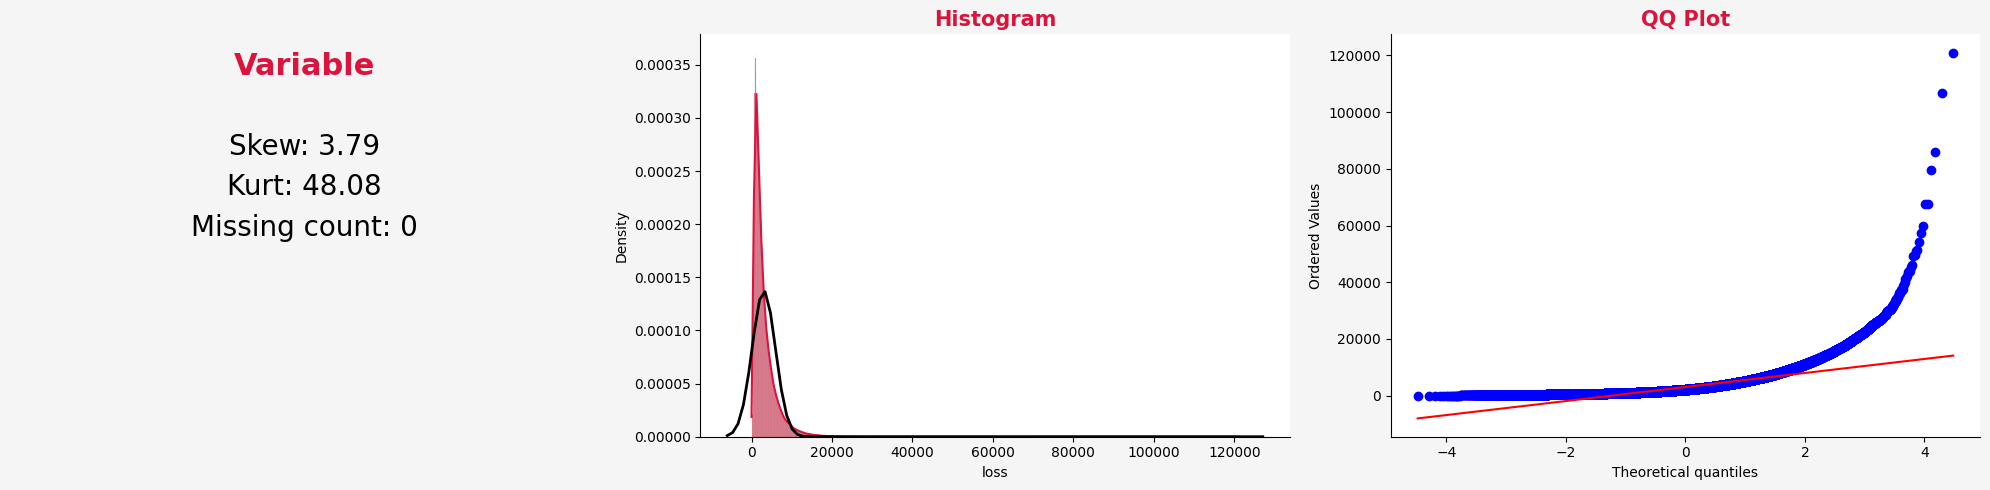

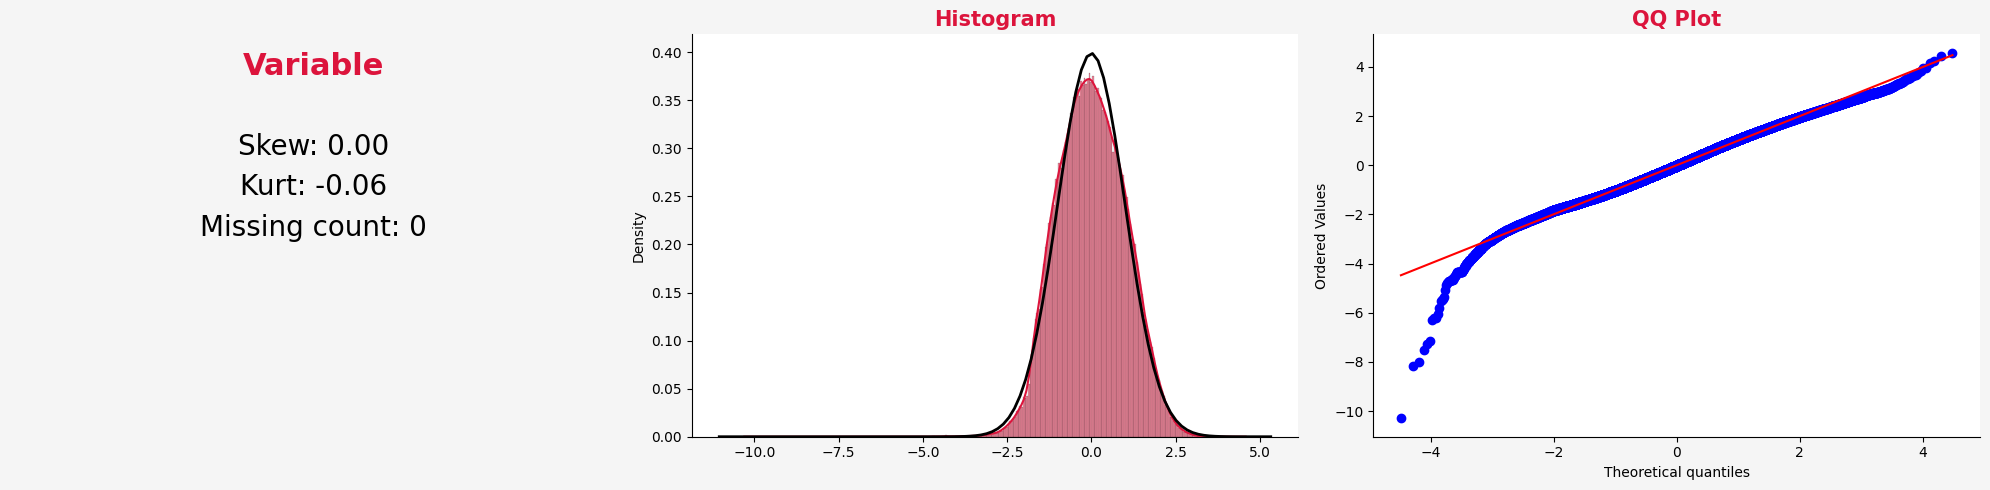

In [9]:
eda = my_EDA()
dirp(eda)

y = train.loss

plot_variable_distribution(y)
plot_variable_distribution(y, use_yeo_johnson=True)


---

Vamos a evaluar tres metodologías para la normalización:

1. **Evaluación Baseline**: Evaluaremos los datos tal como están utilizando nuestra función base.

2. **Transformación Matemática**: Transformaremos matemáticamente la variable dependiente para normalizarla y luego entrenaremos un XGBRegressor.

3. **Filtrado de Valores Atípicos y Normalización**: Filtraremos los valores atípicos específicos de nuestra variable dependiente y, posteriormente, la normalizaremos con una transformación Yeo-Johnson.

---

In [10]:
eda.info(train)

====> This data contains 188318 rows and 131 columns

FEATURE NAME  DATA FORMAT   NULL VALUES(NUM-PERC)          SEVEN SAMPLES  
------------  -----------   ---------------------          -------------  
loss            float64        0 - nan %           1795.03,1841.78,11077.71,10001.22,5612.95,1237.64,482.32,
cat1            object         0 - nan %           B,A,A,B,B,A,A,
cat2            object         0 - nan %           B,A,B,A,A,A,A,
cat116          object         0 - nan %           DK,HG,GS,HK,GN,HV,DJ,
cont1           float64        0 - nan %           0.465671,0.637419,0.8464,0.324129,0.304143,0.165709,0.658579,
cont2           float64        0 - nan %           0.199504,0.681761,0.681761,0.620805,0.785784,0.555782,0.785784,
cont3           float64        0 - nan %           0.506105,0.397983,0.57136,0.65431,0.280933,0.692825,0.336963,
cont4           float64        0 - nan %           0.83324,0.327354,0.215482,0.809278,0.463029,0.432728,0.679338,
cont5           float64    

,count,mean,std,min,25%,50%,75%,max
cont1,188318.0,0.493861,0.187640,0.000016,0.346090,0.475784,0.623912,0.984975
cont2,188318.0,0.507188,0.207202,0.001149,0.358319,0.555782,0.681761,0.862654
cont3,188318.0,0.498918,0.202105,0.002634,0.336963,0.527991,0.634224,0.944251
cont4,188318.0,0.491812,0.211292,0.176921,0.327354,0.452887,0.652072,0.954297
cont5,188318.0,0.487428,0.209027,0.281143,0.281143,0.422268,0.643315,0.983674
cont6,188318.0,0.490945,0.205273,0.012683,0.336105,0.440945,0.655021,0.997162
cont7,188318.0,0.484970,0.178450,0.069503,0.350175,0.438285,0.591045,1.000000
cont8,188318.0,0.486437,0.199370,0.236880,0.312800,0.441060,0.623580,0.980200
cont9,188318.0,0.485506,0.181660,0.000080,0.358970,0.441450,0.566820,0.995400
cont10,188318.0,0.498066,0.185877,0.000000,0.364580,0.461190,0.614590,0.994980


no vemos valores anormales y al no tener valores faltantes no es necesaria la imputacion en este caso

In [11]:
def unique_values(df):
        # Crear un DataFrame para almacenar los valores únicos y tipos de datos
        b = pd.DataFrame()
        b['N unique values'] = df.nunique()
        b['dtype'] = df.dtypes
        
        # Ordenar el DataFrame por el número de valores únicos de mayor a menor
        b = b.sort_values(by='N unique values', ascending=False)
        
        return b

num_vars, cat_vars = eda.vars_list(train)
unique_values(train[cat_vars])

,N unique values,dtype
cat116,326,object
cat110,131,object
cat109,84,object
cat113,61,object
cat112,51,object
...,...,...
cat5,2,object
cat6,2,object
cat7,2,object
cat8,2,object


## 1.2 exploramos variables numericas

In [12]:
# eda.exploration_num(train)

## 1.3 exploramos variables categoricas

In [13]:
# eda.exploration_cat(train, 'loss')

#### Inferimos lo siguiente:

Distribución de los datos:

Algunas categorías ("cat") tienen distribuciones más simétricas (forma de campana), mientras que otras son más sesgadas (con una cola más larga hacia un lado).

La dispersión de los datos varía entre las categorías. Algunas tienen un rango mayor que otras.

**Comparación entre categorías:**

Podemos comparar visualmente la mediana, el IQR y la forma general de la distribución entre las diferentes categorías.

Por ejemplo, en "cat79" la mediana es más alta que en "catBD" y la distribución parece más sesgada hacia la "derecha".

## 1.4 Bivariate search - correlation analysis, heat map, encontrando variables de imporntacia

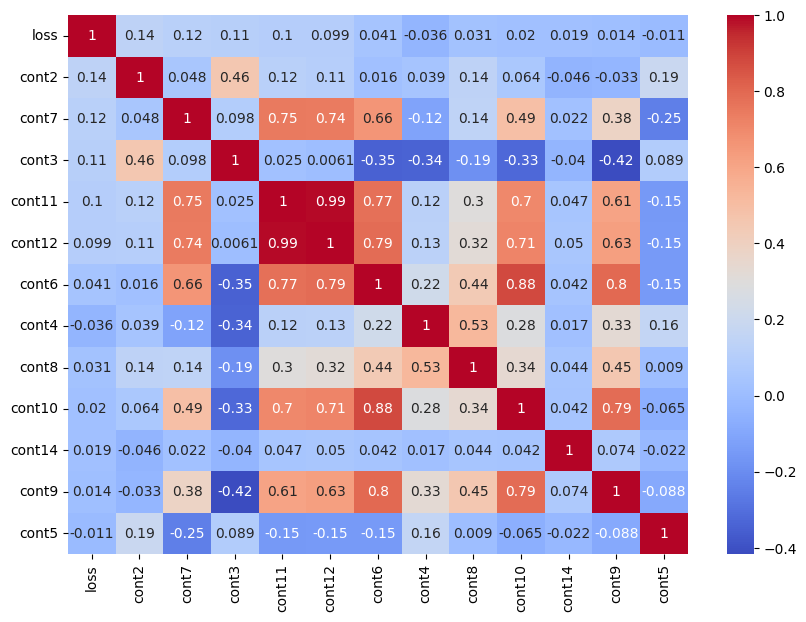

In [14]:
corr = eda.plot_high_corr_heatmap(train, 'loss')

In [15]:
corr = corr.drop("loss")
corr = list(corr)
corr

['cont2',
 'cont7',
 'cont3',
 'cont11',
 'cont12',
 'cont6',
 'cont4',
 'cont8',
 'cont10',
 'cont14',
 'cont9',
 'cont5']


# Definir BaseLine

Para evaluar diferentes metodologías basadas en el preprocesamiento y la ingeniería de características en aprendizaje automático, con el fin de evaluar la efectividad de cada implementación.

---

In [16]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

def score_mae(X, y, model=XGBRegressor()):
    
    scores = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_absolute_error"
    )
   
    scores = -scores
    score_mean = scores.mean()
    score_std = scores.std()
    
    print(f"Mean Absolute Error score \n - Mean: {score_mean:.5f} \n - StdDev: {score_std:.5f}")
    
    return score_mean



# Definir la función de evaluación con K-Fold Cross-Validation
def scores(X, y, model=XGBRegressor()):
    
    # Definir los K-Folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Crear los "scorers" para cada métrica
    scorers = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error, greater_is_better=False),
        'mse': make_scorer(mean_squared_error, greater_is_better=False)
    }
    
    # Realizar la validación cruzada
    scores = cross_validate(model, X, y, cv=kf, scoring=scorers, return_train_score=False)
    
    # Calcular las medias y desviaciones estándar
    r2_mean = scores['test_r2'].mean()
    r2_std = scores['test_r2'].std()
    
    mae_mean = -scores['test_mae'].mean()  # Los errores negativos se transforman en positivos
    mae_std = scores['test_mae'].std()
    
    mse_mean = -scores['test_mse'].mean()  # Los errores negativos se transforman en positivos
    mse_std = scores['test_mse'].std()
    
    # Imprimir los resultados
    print(f"R^2 Score: \n - Mean: {r2_mean:.5f} \n - StdDev: {r2_std:.5f}")
    print(f"MAE Score: \n - Mean: {mae_mean:.5f} \n - StdDev: {mae_std:.5f}")
    print(f"MSE Score: \n - Mean: {mse_mean:.5f} \n - StdDev: {mse_std:.5f}")
    
    return r2_mean, mae_mean, mse_mean

# Ejemplo de uso
# X y y son tus datos de entrada y salida
# X, y = ...
# score_metrics(X, y, model=XGBRegressor())




## 2.1 Comparando encoders

In [17]:
pre = my_preproc()
pre


pre-processing object is created



In [18]:
def separar(df, train):
    train_shape = train.shape[0]
    train = df.iloc[:train_shape,:]
    test = df.iloc[train_shape:,:]
    return train, test

In [19]:
dirp(eda)

['create_features', 'data', 'exploration_cat', 'exploration_num', 'get_missing_values', 'hypo_test', 'info', 'missing_values', 'plot_high_corr_heatmap', 'plot_missing', 'plot_variable_distribution', 'scarplot_strongs_vars', 'unique_values', 'vars_list']


None

#### label encoder

In [20]:
# def pipe():
#     train_df,test_df = load()
#     all_data = pd.concat([train_df,test_df], axis = 0)

#     # encoding
#     num_vars, cat_vars = eda.vars_list(all_data)
#     all_data = pre.label_encoder(all_data, cat_vars)

#     train, test = separar(all_data,train_df)

#     y=train['loss']
#     X=train.drop('loss', axis=1)

#     score_mae(X,y)

# pipe()

#### creamos nuevas caracterticas numericas polinomicas y evaluamos

In [21]:
# def pipe2():
#     train_df,test_df = load()
#     y = train_df.pop("loss")
#     all_data = pd.concat([train_df,test_df], axis = 0)
    
#     # encoding
#     num_vars, cat_vars = eda.vars_list(all_data)
#     all_data = eda.create_features(all_data, corr)
#     all_data = pre.label_encoder(all_data, cat_vars)

#     train, test = separar(all_data,train_df)
    
#     X=train

#     s = score_mae(X,y)
#     return s

# pipe2()

### one hot encoding

In [22]:

# # encoding. one hot
# def pipe3():
#     train_df,test_df = load()
#     y = train_df.pop("loss")
#     all_data = pd.concat([train_df,test_df], axis = 0)
    
#     # encoding
#     num_vars, cat_vars = eda.vars_list(all_data)
#     all_data = eda.create_features(all_data, corr)
#     # all_data = pre.label_encoder(all_data, cat_vars)
#     all_data = pre.get_dummies(all_data,cat_vars)

#     train, test = separar(all_data,train_df)
    
#     X=train

#     # boost gradient tree model
#     s = score_mae(X,y)
#     return s

# pipe3()
# """
# Mean Absolute Error score 
#  - Mean: 1200.67857 
#  - StdDev: 6.52660
# """

### probamos segun alta cardinalidad(label encoding)[>15] y baja cardinalidad [<15](one hot encoding)

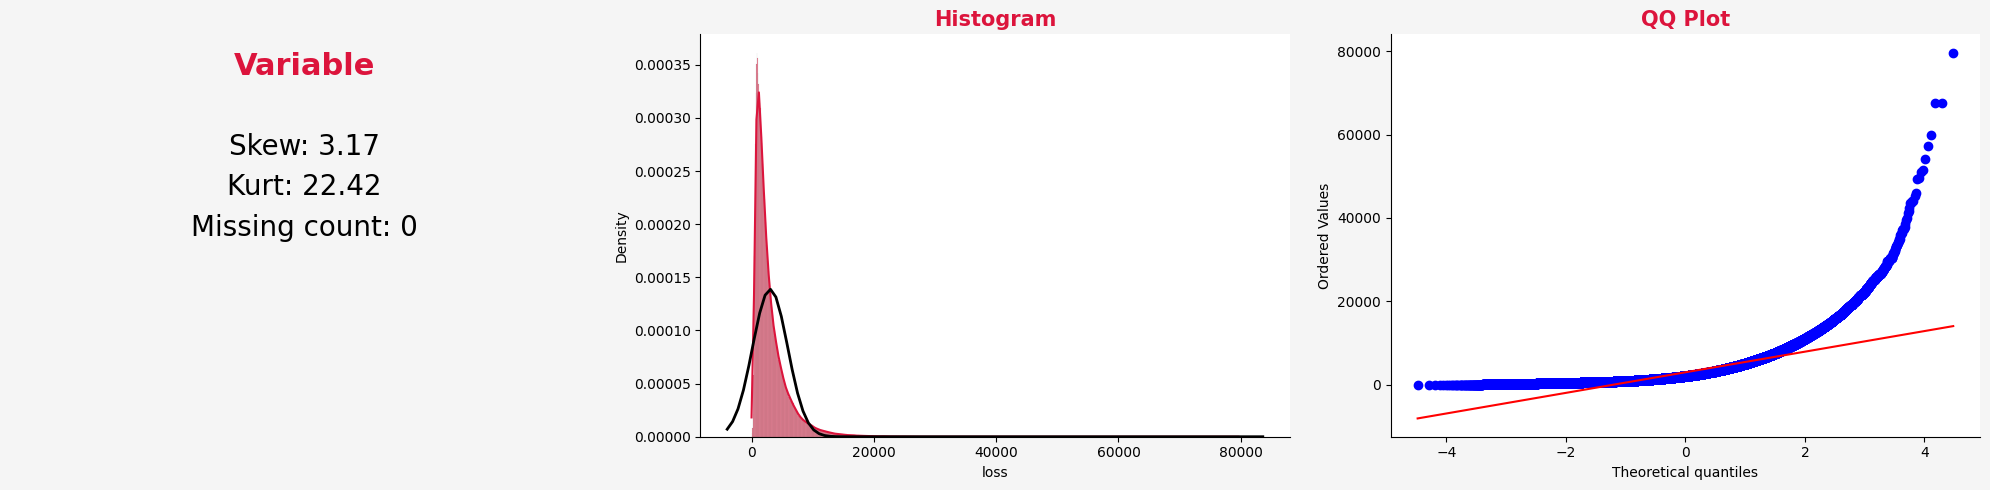

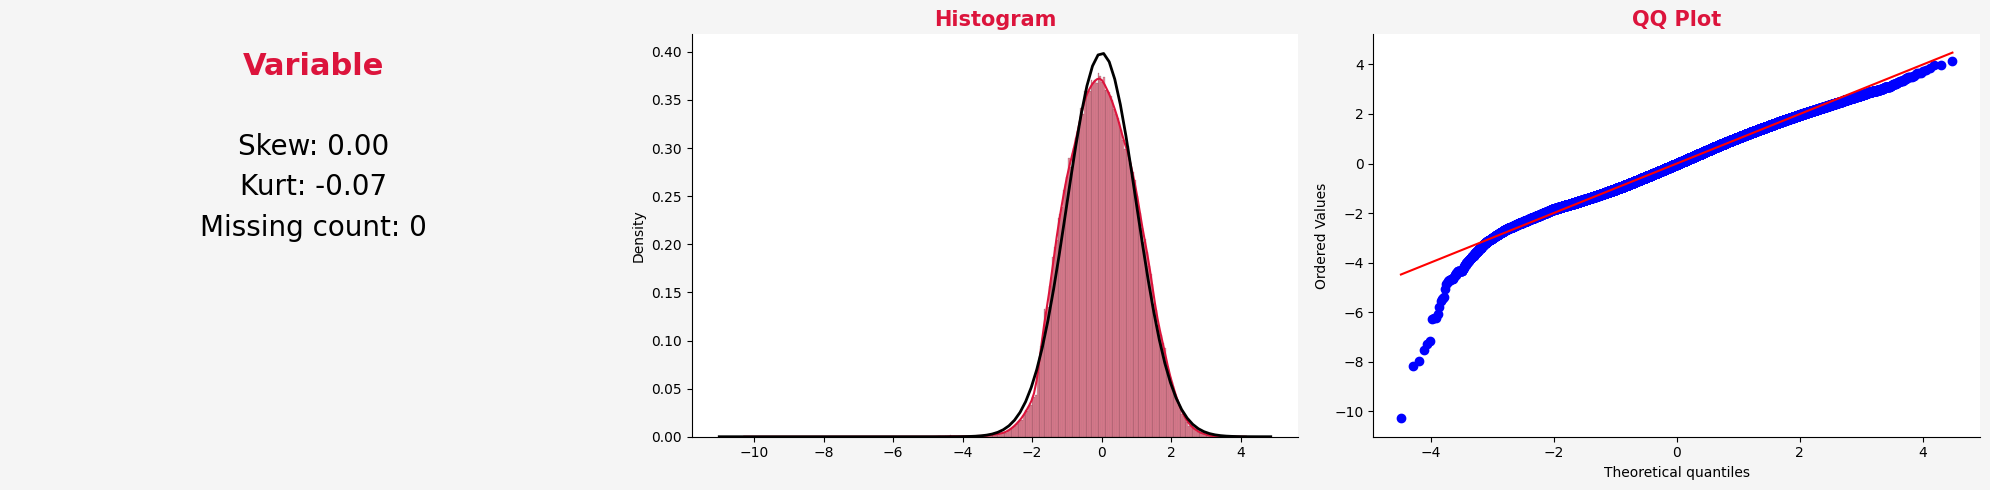

In [23]:
train_df,test_df = load()
y = train_df.pop("loss")
y = y.dropna()
y = y[y<85000]
plot_variable_distribution(y)
plot_variable_distribution(y, use_yeo_johnson=True)

In [24]:
def HL_cardinality_cols(df):
    """
    return numerical_cols, high_cardinality_cols, low_cardinality_cols. list of str
    """
    #entra un df, y salen listas de las columnas de alta, baja cardinalidad, y de columnas numericas
    #return : numerical_cols, high_cardinality_cols, low_cardinality_cols
    # Verifica si df es un DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError("El argumento debe ser un DataFrame de Pandas.")
    
    numerical_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
    high_cardinality_cols = [cname for cname in df.columns if df[cname].nunique() >= 15 and df[cname].dtype == "object"]
    low_cardinality_cols = [cname for cname in df.columns if df[cname].nunique() < 15 and df[cname].dtype == "object"]
 
    return numerical_cols, high_cardinality_cols, low_cardinality_cols

In [25]:
# prueba 3 
from sklearn.preprocessing import PowerTransformer
from xgboost import XGBRegressor
import optuna

# aplicamos fitlramos valores atipicos y normalizamos nuestra variable dependiente
def pipe4():
    # Crear y ajustar el transformador de Yeo-Johnson
    transformer = PowerTransformer(method='yeo-johnson')

    train_df, test_df = load()

    # Concatenar los datos de entrenamiento y prueba
    all_data = pd.concat([train_df, test_df], axis=0)

    # Separar variables numéricas y categóricas
    num_vars, high_cat_vars, low_cat_vars = HL_cardinality_cols(all_data)
    all_data = eda.create_features(all_data, corr)

    # Encoding de variables categóricas
    all_data = pre.get_dummies(all_data, low_cat_vars)
    all_data = pre.label_encoder(all_data, high_cat_vars)

    

    # Separar nuevamente en datos de entrenamiento y prueba
    train, test = separar(all_data, train_df)

    # Filtrar los datos de entrenamiento según la distribución observada
    train = train[train['loss'] < 86000]

    # Crear una instancia del transformador Yeo-Johnson
    yj_transformer = yjtransformer()

    # Aplicar fit_transform a la columna 'y'
    train = yj_transformer.fit_transform(train, 'loss')

    # Separar la variable objetivo 'y' del resto de las características
    y = train['loss']
    X = train.drop('loss', axis=1)

    

    # Mostrar los primeros registros de X y las dimensiones de X
    display(X.head())
    display(X.shape)
    
    # XGBRegressor
    s = scores(X,y)
    return s


"""
R^2 Score: 
 - Mean: 0.54724 
 - StdDev: 0.00294
MAE Score: 
 - Mean: 0.51968 
 - StdDev: 0.00278
MSE Score: 
 - Mean: 0.45276 
 - StdDev: 0.00601
"""


'\nR^2 Score: \n - Mean: 0.54724 \n - StdDev: 0.00294\nMAE Score: \n - Mean: 0.51968 \n - StdDev: 0.00278\nMSE Score: \n - Mean: 0.45276 \n - StdDev: 0.00601\n'

In [26]:
# num_vars[:-1]
corr

['cont2',
 'cont7',
 'cont3',
 'cont11',
 'cont12',
 'cont6',
 'cont4',
 'cont8',
 'cont10',
 'cont14',
 'cont9',
 'cont5']

# Feature enginering - testing

buscando valores atipicos en neustras variables numericas de mayor importancia

In [27]:
# dirp(eda)
# eda.scarplot_strongs_vars(train,'loss', corr)

aislamos una porcion de los datos para ejecutar pruebas rapidamente

# "achicar" _>> sample for FE

In [28]:
# dada la presencia de valores atipicos usaremos escaladores robustos de sklearn

# para evaluar la logica conviene usar "samples" o ejemplos a fin de evaluar rapidamente. una ves que esta fucniona
# podemos aplicarla en el set de datos mas grande.

# Goal: maximize r2 score
#1) aplicamos fitlramos valores atipicos y normalizamos nuestra variable dependiente
# Conclusion : vimos una mejora en nuestro r2. 0.5178-> 0.5412

#2) utilizamos escaladores robustos para columnas numericas, creamos caract. polinomicas y creamos ratios de aquellas mas correlacionadas
# Conclusion. Vimos una ligera mejora en nuestro r2. 0.5412 -> 0.547

#3) Vamos a normalizar todas las variables numericas, y vamos a utilizar un min max escaler .
# Conclusion: Vimos una  mejora en las velocidad de entrenamiento pese a una disminucion de nuestro 
# r2. 0.547 -> 0.544

def pipe5():
    # Crear y ajustar el transformador de Yeo-Johnson
    transformer = PowerTransformer(method='yeo-johnson')

    train_df, test_df = load()

    # Concatenar los datos de entrenamiento y prueba
    all_data = pd.concat([train_df, test_df], axis=0)

    # Separar variables numéricas y categóricas
    num_vars, high_cat_vars, low_cat_vars = HL_cardinality_cols(all_data)
    all_data = eda.create_features(all_data, corr)

    # Encoding de variables categóricas
    all_data = pre.get_dummies(all_data, low_cat_vars)
    all_data = pre.label_encoder(all_data, high_cat_vars)

    #usamos escalador robusto de scikit learn a 
    all_data[num_vars[:-1]]=pre.scaler_data_Robust(all_data[num_vars[:-1]], num_vars[:-1])  # todas las columnas numericas menos "loss " que es nuestra variable objetivo
    
    #normalizamos distribuciones de las variables numericas y luego escalamos
    all_data[num_vars[:-1]] = Normalize_and_min_max(all_data[num_vars[:-1]])
    
    # Separar nuevamente en datos de entrenamiento y prueba
    train, test = separar(all_data, train_df)

    # Filtrar los datos de entrenamiento según la distribución observada
    train = train[train['loss'] < 86000]

    # Crear una instancia del transformador Yeo-Johnson
    yj_transformer = yjtransformer()

    # Aplicar fit_transform a la columna 'y'
    train = yj_transformer.fit_transform(train, 'loss')

    # Separar la variable objetivo 'y' del resto de las características
    y = train['loss']
    X = train.drop('loss', axis=1)

    # Mostrar los primeros registros de X y las dimensiones de X
    display(X.head())
    display(X.shape)
    
    # XGBRegressor
    s = scores(X,y)
    return s

# pipe5()

In [ ]:


# Crear y ajustar el transformador de Yeo-Johnson
transformer = PowerTransformer(method='yeo-johnson')

train_df, test_df = load()

# Concatenar los datos de entrenamiento y prueba
all_data = pd.concat([train_df, test_df], axis=0)

# Separar variables numéricas y categóricas
num_vars, high_cat_vars, low_cat_vars = HL_cardinality_cols(all_data)
all_data = eda.create_features(all_data, corr)

# Encoding de variables categóricas
all_data = pre.get_dummies(all_data, low_cat_vars)
all_data = pre.label_encoder(all_data, high_cat_vars)

# Usamos escalador robusto de scikit-learn a 
all_data[num_vars[:-1]] = pre.scaler_data_Robust(all_data[num_vars[:-1]], num_vars[:-1])  # Todas las columnas numéricas menos "loss" que es nuestra variable objetivo

# Normalizamos distribuciones de las variables numéricas y luego escalamos
all_data[num_vars[:-1]] = Normalize_and_min_max(all_data[num_vars[:-1]])

# Separar nuevamente en datos de entrenamiento y prueba
train, test = separar(all_data, train_df)

# Filtrar los datos de entrenamiento según la distribución observada
train = train[train['loss'] < 86000]

# Crear una instancia del transformador Yeo-Johnson
yj_transformer = yjtransformer()

# Aplicar fit_transform a la columna 'y'
train = yj_transformer.fit_transform(train, 'loss')

# Separar la variable objetivo 'y' del resto de las características
y = train['loss']
X = train.drop('loss', axis=1)

"""
Trial 14 finished with value: 0.5126647313983244 and parameters: {'max_depth': 8, 
'learning_rate': 0.008663219459131738, 'n_estimators': 2853, 'min_child_weight': 9, 
'colsample_bytree': 0.8477255753417361, 'subsample': 0.8016845613211243, 'reg_alpha': 0.00012143043389996245, 
'reg_lambda': 95.61695636281313}. Best is trial 14 with value: 0.5126647313983244.
"""

# Mejor configuración de hiperparámetros (Trial 14)
xgb_params = {
    'max_depth': 8, 
    'learning_rate': 0.008663219459131738, 
    'n_estimators': 2853, 
    'min_child_weight': 9, 
    'colsample_bytree': 0.8477255753417361, 
    'subsample': 0.8016845613211243, 
    'reg_alpha': 0.00012143043389996245, 
    'reg_lambda': 95.61695636281313,
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor'
}

# Definir el modelo con los mejores hiperparámetros
model = XGBRegressor(**xgb_params)

# Evaluar el modelo con los mejores hiperparámetros
scores(X, y, model)



In [ ]:
xgb.fit(X, y)

predictions_ = xgb.predict(test)
# Reformatear predictions_ para que sea un array 2D
predictions_2D = predictions_.reshape(-1, 1)

# Aplicar la transformación inversa
predictions = transformer.inverse_transform(predictions_2D)

# Si quieres volver a un array 1D después de la transformación inversa
predictions = predictions.flatten()

output = pd.DataFrame({'ID': test.index, 'loss': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")


